In [1]:
import tifffile
import pandas
from griottes import generate_contact_graph, generate_delaunay_graph, generate_geometric_graph, plot_2D

import urllib3
import shutil
import os

import matplotlib.pyplot as plt
import seaborn as sns

# I. Description

This notebook enables the user to reproduce the panels from figure 2 of ["Griottes: a generalist tool for network generation from segmented tissue images"](https://www.biorxiv.org/content/10.1101/2022.01.14.476345v1). The first part of the document shows how to generate a graph object from a segmented image using the contact-based network construction method. The second part of the notebook contains the code corresponding to the more advanced analysis shown in the paper to demonstrate the power of network-based analysis methods. The data are available on the github release and will be directly downloaded to the local repository.

## 1. Load image and mask of nuclei

First download the image from the latest release of `Griottes` from the GitHub release and load the image to the notebook.

In [2]:
url = 'https://github.com/BaroudLab/Griottes/releases/download/v1.0-alpha/zebrafish_brain_cell_labels.tiff'
filename = 'zebrafish_brain_cell_labels.tiff'

if not os.path.exists(filename):
    c = urllib3.PoolManager()

    with c.request('GET',url, preload_content=False) as resp, open(filename, 'wb') as out_file:
        shutil.copyfileobj(resp, out_file)

    resp.release_conn()
else:
    print('dataset already exists')
    
sub_image = tifffile.imread(filename)

dataset already exists


## 2. Generating a contact graph

From the masks of the complete cells we can build the contact graph of the network, connecting together cells sharing a common border.

In [3]:
G_contact = generate_contact_graph(sub_image[..., 4],
                                                 analyze_fluo_channels=False, 
                                                 radius = 100)

The input image has 2 dimensions, it will be analyzed as a labeled image.


## 3. Plotting a representation of the graph

From the graph `G` it is possible to plot a visual representation of the network. To facilitate this, `Griottes` contains several specific plotting functions adapted for the network representation of tisssues.

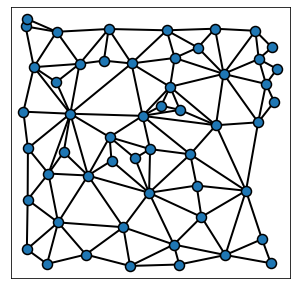

In [4]:
plot_2D(G_contact,
                figsize = (5,5),
                alpha_line = 1,
                scatterpoint_size = 10,
                legend = True,
                edge_color = 'k',
                line_factor = 2)

Adding the `background_image` variable allows to plot the network on to the tissue image of your choice. Notice that we change the edge color to white at the same time:

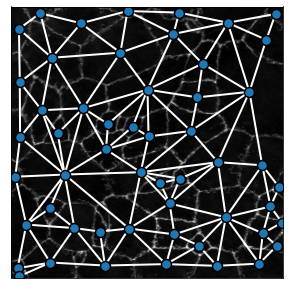

In [5]:
plot_2D(G_contact,
                background_image = sub_image[:, :,1],
                figsize = (5,5),
                alpha_line = 1,
                scatterpoint_size = 10,
                legend = True,
                edge_color = 'w',
                line_factor = 2)

The `generate_contact_graph` method can measure the strength of the bond between two cells as a function of the shared boundary size. This can be shown by changing the parameter `include_weights = True`, revealing the width of each link as a function of the contact size between two cells:

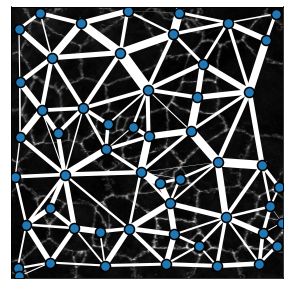

In [6]:
plot_2D(G_contact,
        background_image = sub_image[:, :,1],
        include_weights = True,
        figsize = (5,5),
        alpha_line = 1,
        scatterpoint_size = 10,
        legend = True,
        edge_color = 'w',
        line_factor = 0.15)

# II. Estimating the properties of the tissue graphs

We have shown how we can generate contact-based graphs from segmented images containing the whole cell. We can also build geometric graphs and Delaunay graphs from these images as shown in the cells immediately below. The purpose of the second half of the notebook is to compare the statistics of these graphs and illustrate applications of the network construction method.

## 1. Geometric graphs

We can build geometric graphs of the segmented image using the `generate_geometric_graph` method. The maximum cell-cell distance authorized in the graph is set by the `radius` parameter. For practical purposes it will be set to 100px in the ulterior examples

The input image has 2 dimensions, it will be analyzed as a labeled image.


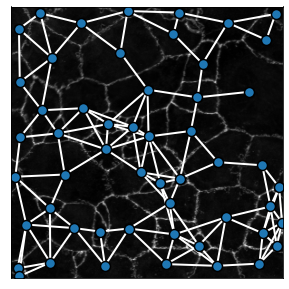

In [9]:
G_geometric = generate_geometric_graph(sub_image[..., 4],
                                   analyze_fluo_channels=False, 
                                   radius = 50)

plot_2D(G_geometric,
        background_image = sub_image[:, :,1],
        figsize = (5,5),
        alpha_line = 1,
        scatterpoint_size = 10,
        legend = True,
        edge_color = 'w',
        line_factor = 2)

## 2. Delaunay graphs

We can build Delaunay graphs of the segmented image using the `generate_delaunay_graph` method. Contrary to a "pure" Delaunay graph, the method has an option to remove links that are beyond a given radius, thereby removing unrealistic connections in the tissue. The maximum cell-cell distance authorized in the graph is here also set by the `radius` parameter.

The input image has 2 dimensions, it will be analyzed as a labeled image.


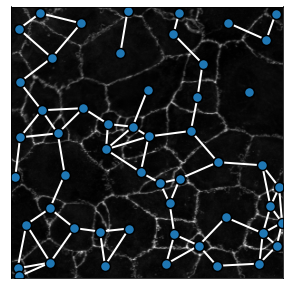

In [11]:
G_delaunay = generate_delaunay_graph(sub_image[..., 4],
                                   analyze_fluo_channels=False, 
                                   radius = 50)

plot_2D(G_delaunay,
        background_image = sub_image[:, :,1],
        figsize = (5,5),
        alpha_line = 1,
        scatterpoint_size = 10,
        legend = True,
        edge_color = 'w',
        line_factor = 2)

## 3. Comparing graph construction properties

The different graph construction methods can be compared by looking at the mean number of links as a function of the graph construction method for example.

In [12]:
url = 'https://github.com/BaroudLab/Griottes/releases/download/v1.0-alpha/zebrafish_brain_cell_labels_whole_cut.tiff'
filename = 'zebrafish_brain_cell_labels_whole_cut.tiff'

if not os.path.exists(filename):
    c = urllib3.PoolManager()

    with c.request('GET',url, preload_content=False) as resp, open(filename, 'wb') as out_file:
        shutil.copyfileobj(resp, out_file)

    resp.release_conn()
else:
    print('dataset already exists')

dataset already exists


In [13]:
image = tifffile.imread(filename)

descriptors = ['label', 'x', 'y']

G_contact = generate_contact_graph(image[..., 4],
                                   descriptors = descriptors,
                                   analyze_fluo_channels=False, 
                                   radius = 100)

G_geometric = generate_geometric_graph(image[..., 4],
                                   descriptors = descriptors,
                                   analyze_fluo_channels=False, 
                                   radius = 100)

G_delaunay = generate_delaunay_graph(image[..., 4],
                                   descriptors = descriptors,
                                   analyze_fluo_channels=False, 
                                   radius = 100)

The input image has 2 dimensions, it will be analyzed as a labeled image.
The input image has 2 dimensions, it will be analyzed as a labeled image.
The input image has 2 dimensions, it will be analyzed as a labeled image.


For instance, we can compare the different neighborhoods generated for each cell as a function of the network construction method. Cell by cell we compare the degrees, using the contact-based properties as a ground truth: 

In [14]:
degree_array = pandas.DataFrame()
j = 0

for node in G_contact.nodes():
    
    label = G_contact.nodes[node]['label']
    
    if label > 0:
    
        node_in_geometric_graph = [i for i in G_geometric.nodes() if G_geometric.nodes[i]['label'] == label][0]
        node_in_delaunay_graph = [i for i in G_delaunay.nodes() if G_delaunay.nodes[i]['label'] == label][0]

        degree_array.loc[j, 'node'] = node
        degree_array.loc[j, 'label'] = label
        degree_array.loc[j, 'degree_contact'] = G_contact.degree[node]
        degree_array.loc[j, 'degree_geometric'] = G_geometric.degree[node_in_geometric_graph]
        degree_array.loc[j, 'degree_voronoi'] = G_delaunay.degree[node_in_delaunay_graph]

        j += 1

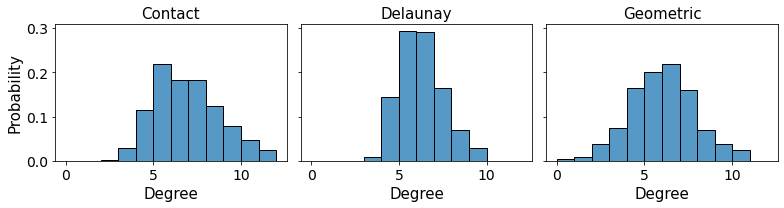

In [15]:
fig, ax = plt.subplots(1,3,figsize = (11,3), sharex = True, sharey = True)
ax[0].tick_params(axis='both', which='major', labelsize=14)
ax[0].tick_params(axis='both', which='minor', labelsize=14)
ax[1].tick_params(axis='both', which='minor', labelsize=14)
ax[1].tick_params(axis='both', which='major', labelsize=14)
ax[2].tick_params(axis='both', which='minor', labelsize=14)
ax[2].tick_params(axis='both', which='major', labelsize=14)

ax[0] = sns.histplot(data = degree_array,
             x = 'degree_contact',
             binwidth = 1,
             ax = ax[0], kde=False, stat = 'probability')

ax[1] = sns.histplot(data = degree_array,
             x = 'degree_voronoi',
             binwidth = 1,
             ax = ax[1], kde=False, stat = 'probability')

ax[2] = sns.histplot(data = degree_array,
             x = 'degree_geometric',
             binwidth = 1,
             ax = ax[2], kde=False, stat = 'probability')

ax[0].set_ylabel('Probability', fontsize = 15)

ax[0].set_xlabel('Degree', fontsize = 15)
ax[1].set_xlabel('Degree', fontsize = 15)
ax[2].set_xlabel('Degree', fontsize = 15)

ax[0].set_title('Contact', fontsize = 15)
ax[1].set_title('Delaunay', fontsize = 15)
ax[2].set_title('Geometric', fontsize = 15)

plt.tight_layout()

The importance of cell-cell contacts ("weights") are contained within the contact-based graph generated by the `generate_contact_graph` method. We can access all the individual weights using `NetworkX` and plot the distribution of cell-cell contacts in the tissue:

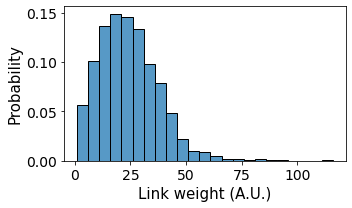

In [16]:
weight_frame = pandas.DataFrame()
i = 0

for u,v,a in G_contact.edges(data=True):
    
    weight_frame.loc[i, 'weight'] = a['weight']
    i += 1
    
fig, ax = plt.subplots(1,1,figsize = (5,3), sharex = True, sharey = True)
ax.tick_params(axis='both', which='major', labelsize=14)
ax.tick_params(axis='both', which='minor', labelsize=14)

ax = sns.histplot(data = weight_frame,
             x = 'weight',
             binwidth = 5,
             ax = ax, kde=False, stat = 'probability')

ax.set_ylabel('Probability', fontsize = 15)
ax.set_xlabel('Link weight (A.U.)', fontsize = 15)

plt.tight_layout()